<a href="https://colab.research.google.com/github/pandu1992/Reinfocement_Learning/blob/main/DQN_Variation_under_different_Network_Effects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/array_slicing.py:62: RuntimeWarning: overflow encountered in cast
  return x.astype(dtype)


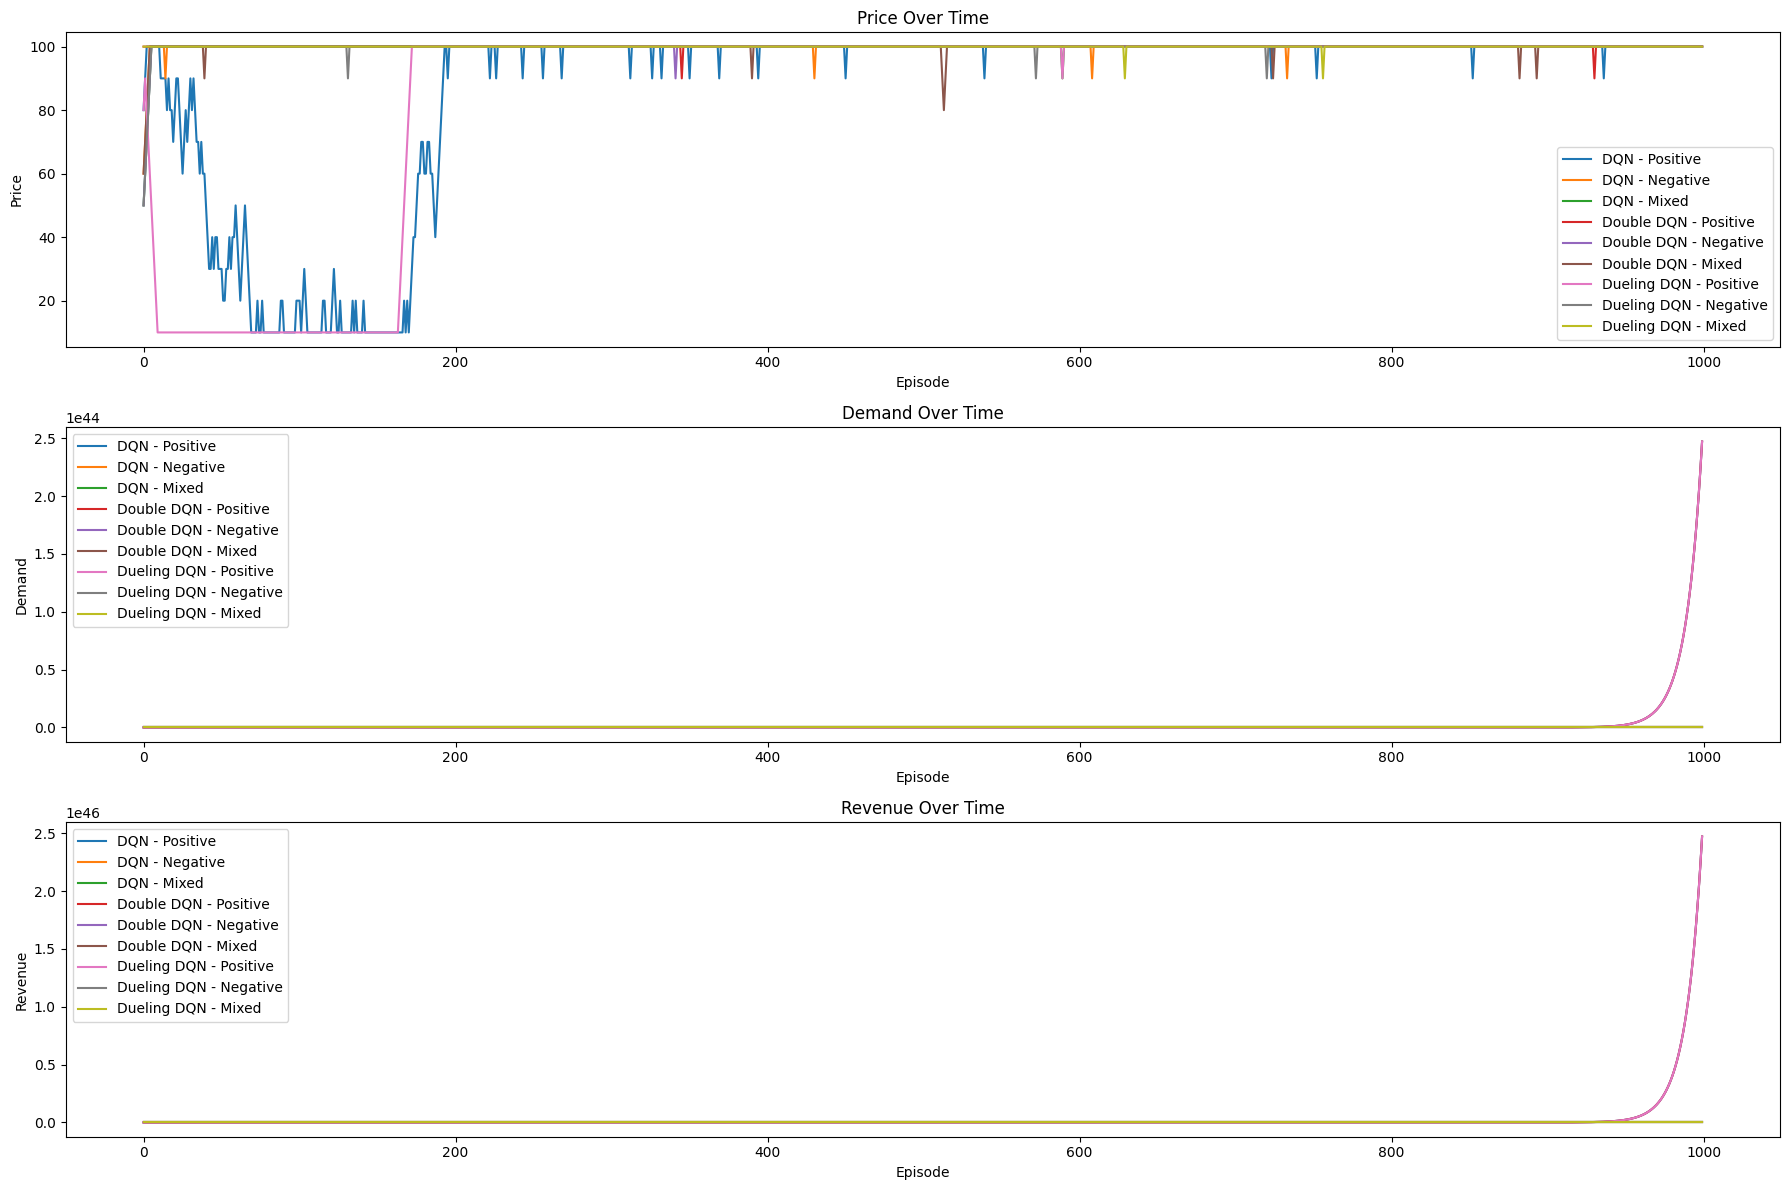

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Lambda
import random
import matplotlib.pyplot as plt
import collections

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Environment parameters
price_range = np.linspace(10, 100, 10)
initial_demand = 1000
episodes = 1000
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
gamma = 0.95
learning_rate = 0.001

# Network effects functions
def positive_network_effect(demand):
    return demand * 1.1

def negative_network_effect(demand):
    return demand * 0.9

def mixed_network_effect(demand):
    if random.random() > 0.5:
        return demand * 1.1
    else:
        return demand * 0.9

# Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size=2000):
        self.buffer = collections.deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states = zip(*batch)
        return np.array(states), actions, rewards, np.array(next_states)

# Dueling DQN model
def build_dueling_dqn_model():
    inputs = Input(shape=(2,))
    hidden = Dense(24, activation='relu')(inputs)
    hidden = Dense(24, activation='relu')(hidden)

    # Dueling Architecture - Separate Value and Advantage streams
    value_stream = Dense(1, activation='linear')(hidden)
    advantage_stream = Dense(3, activation='linear')(hidden)
    q_values = Lambda(lambda v: v[0] + (v[1] - tf.reduce_mean(v[1], axis=1, keepdims=True)))([value_stream, advantage_stream])

    model = Model(inputs=inputs, outputs=q_values)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

# Original DQN Model
def build_dqn_model():
    model = Sequential()
    model.add(Input(shape=(2,)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(3, activation='linear'))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model

# Instantiate models
dqn_model = build_dqn_model()
ddqn_model = build_dqn_model()  # For Double DQN
dueling_dqn_model = build_dueling_dqn_model()

# Initialize target networks
dqn_target_model = build_dqn_model()
dqn_target_model.set_weights(dqn_model.get_weights())

ddqn_target_model = build_dqn_model()
ddqn_target_model.set_weights(ddqn_model.get_weights())

# Simulation Loop Function
def train_model(model, target_model, scenario, batch_size=32, double_dqn=False):
    global epsilon
    results = {"Price": [], "Demand": [], "Revenue": []}
    buffer = ReplayBuffer()
    demand = initial_demand
    price = random.choice(price_range)

    for episode in range(episodes):
        state = np.array([price, demand])

        if np.random.rand() <= epsilon:
            action = random.choice([0, 1, 2])  # Random action
        else:
            action = np.argmax(model.predict(state.reshape(1, 2), verbose=0))

        if action == 0:
            price = min(price + 10, price_range[-1])
        elif action == 1:
            price = max(price - 10, price_range[0])

        if scenario == "Positive":
            demand = positive_network_effect(demand)
        elif scenario == "Negative":
            demand = negative_network_effect(demand)
        elif scenario == "Mixed":
            demand = mixed_network_effect(demand)

        reward = price * demand
        next_state = np.array([price, demand])
        buffer.add((state, action, reward, next_state))

        if len(buffer.buffer) > batch_size:
            states, actions, rewards, next_states = buffer.sample(batch_size)

            # Predict Q-values for current states
            q_values = model.predict(states, verbose=0)

            # Predict Q-values for next states
            if double_dqn:
                # Double DQN: Use main model to select action, target model for evaluation
                next_actions = np.argmax(model.predict(next_states, verbose=0), axis=1)
                q_values_next = target_model.predict(next_states, verbose=0)
                targets = rewards + gamma * q_values_next[np.arange(batch_size), next_actions]
            else:
                # Standard DQN and Dueling DQN
                q_values_next = target_model.predict(next_states, verbose=0)
                targets = rewards + gamma * np.max(q_values_next, axis=1)

            # Update Q-values for the selected actions
            for idx, action in enumerate(actions):
                q_values[idx][action] = targets[idx]

            # Train the main model
            model.fit(states, q_values, epochs=1, verbose=0)

        state = next_state
        results["Price"].append(price)
        results["Demand"].append(demand)
        results["Revenue"].append(reward)

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        if episode % 10 == 0:
            target_model.set_weights(model.get_weights())

    return results

# Run DQN, Double DQN, and Dueling DQN
scenarios = ["Positive", "Negative", "Mixed"]
all_results = {"DQN": {}, "Double DQN": {}, "Dueling DQN": {}}

# Train each model under all scenarios
for scenario in scenarios:
    all_results["DQN"][scenario] = train_model(dqn_model, dqn_target_model, scenario)
    all_results["Double DQN"][scenario] = train_model(ddqn_model, ddqn_target_model, scenario, double_dqn=True)
    all_results["Dueling DQN"][scenario] = train_model(dueling_dqn_model, dueling_dqn_model, scenario)

# Plot results
plt.figure(figsize=(18, 12))

for i, metric in enumerate(["Price", "Demand", "Revenue"]):
    plt.subplot(3, 1, i + 1)
    for model_type in ["DQN", "Double DQN", "Dueling DQN"]:
        for scenario in scenarios:
            plt.plot(all_results[model_type][scenario][metric], label=f"{model_type} - {scenario}")
    plt.title(f"{metric} Over Time")
    plt.xlabel("Episode")
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()


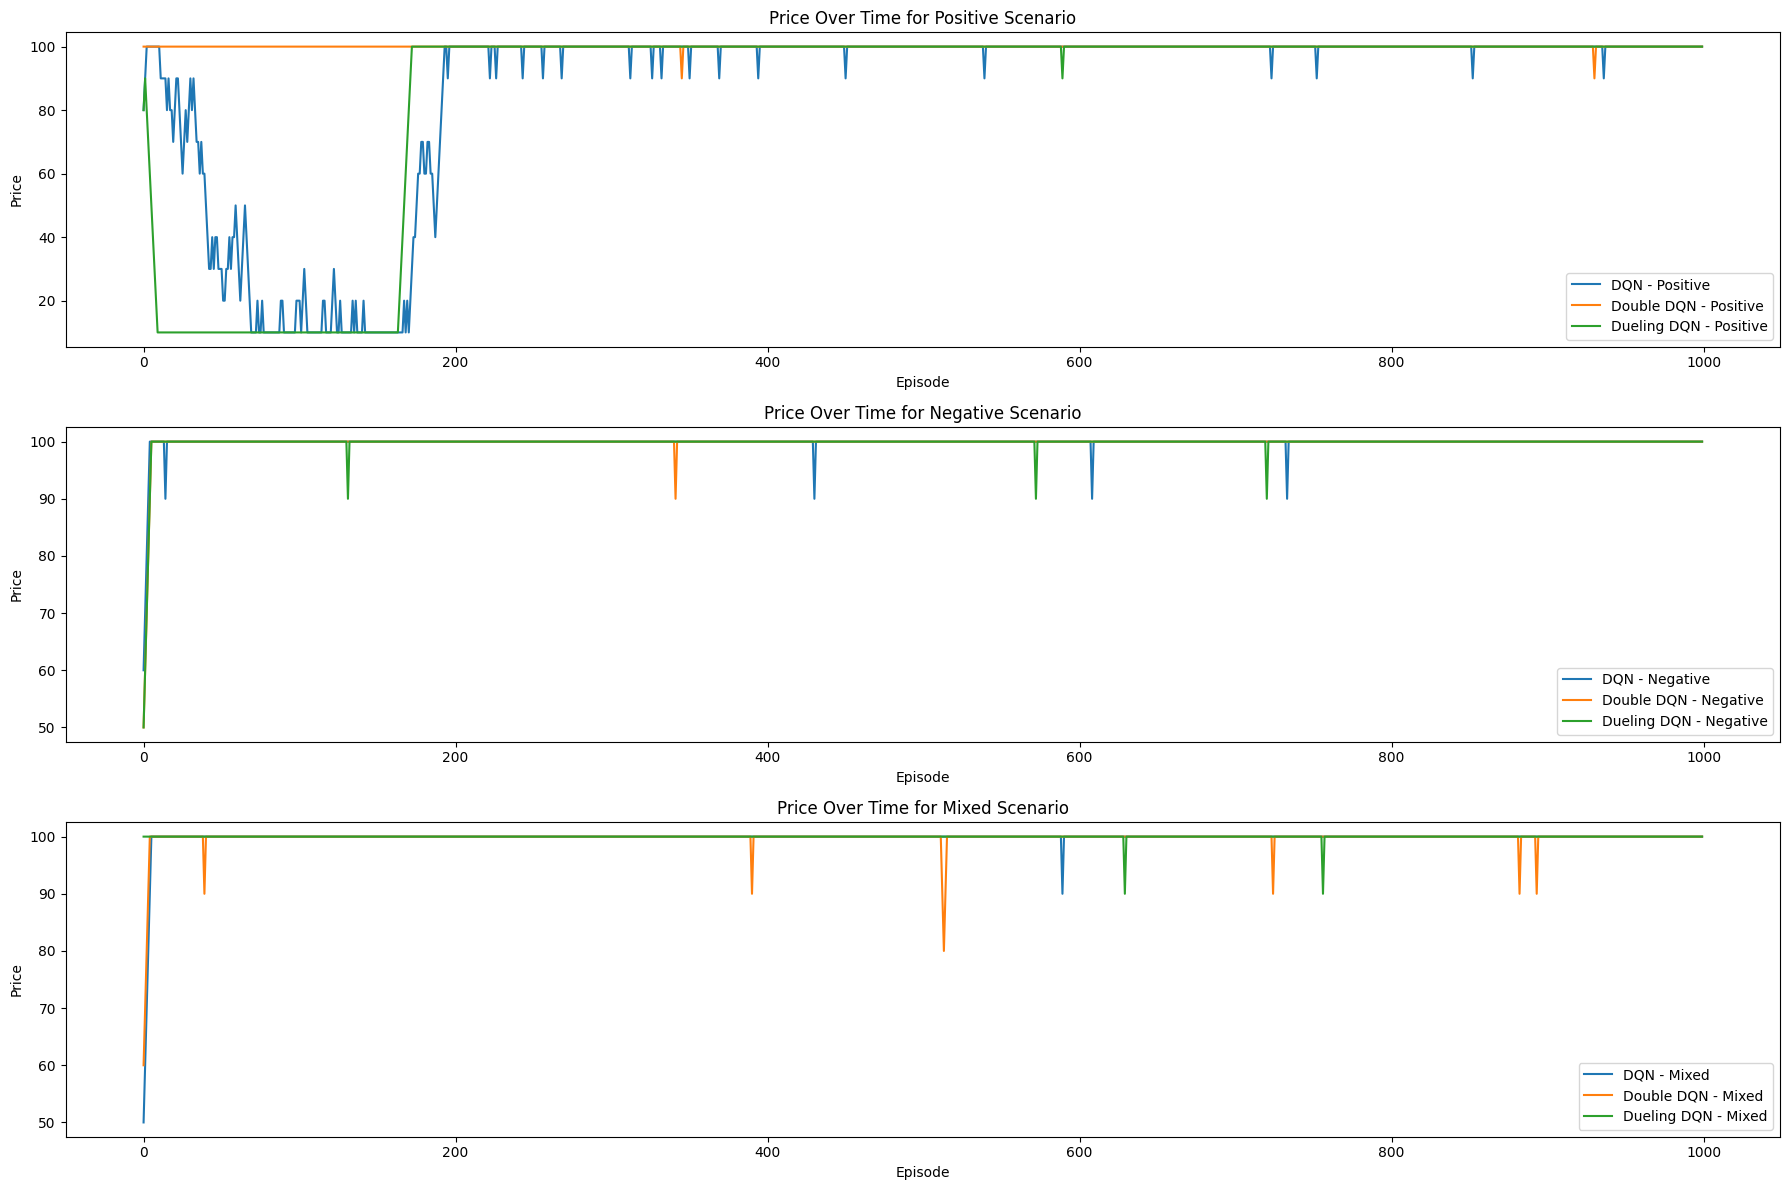

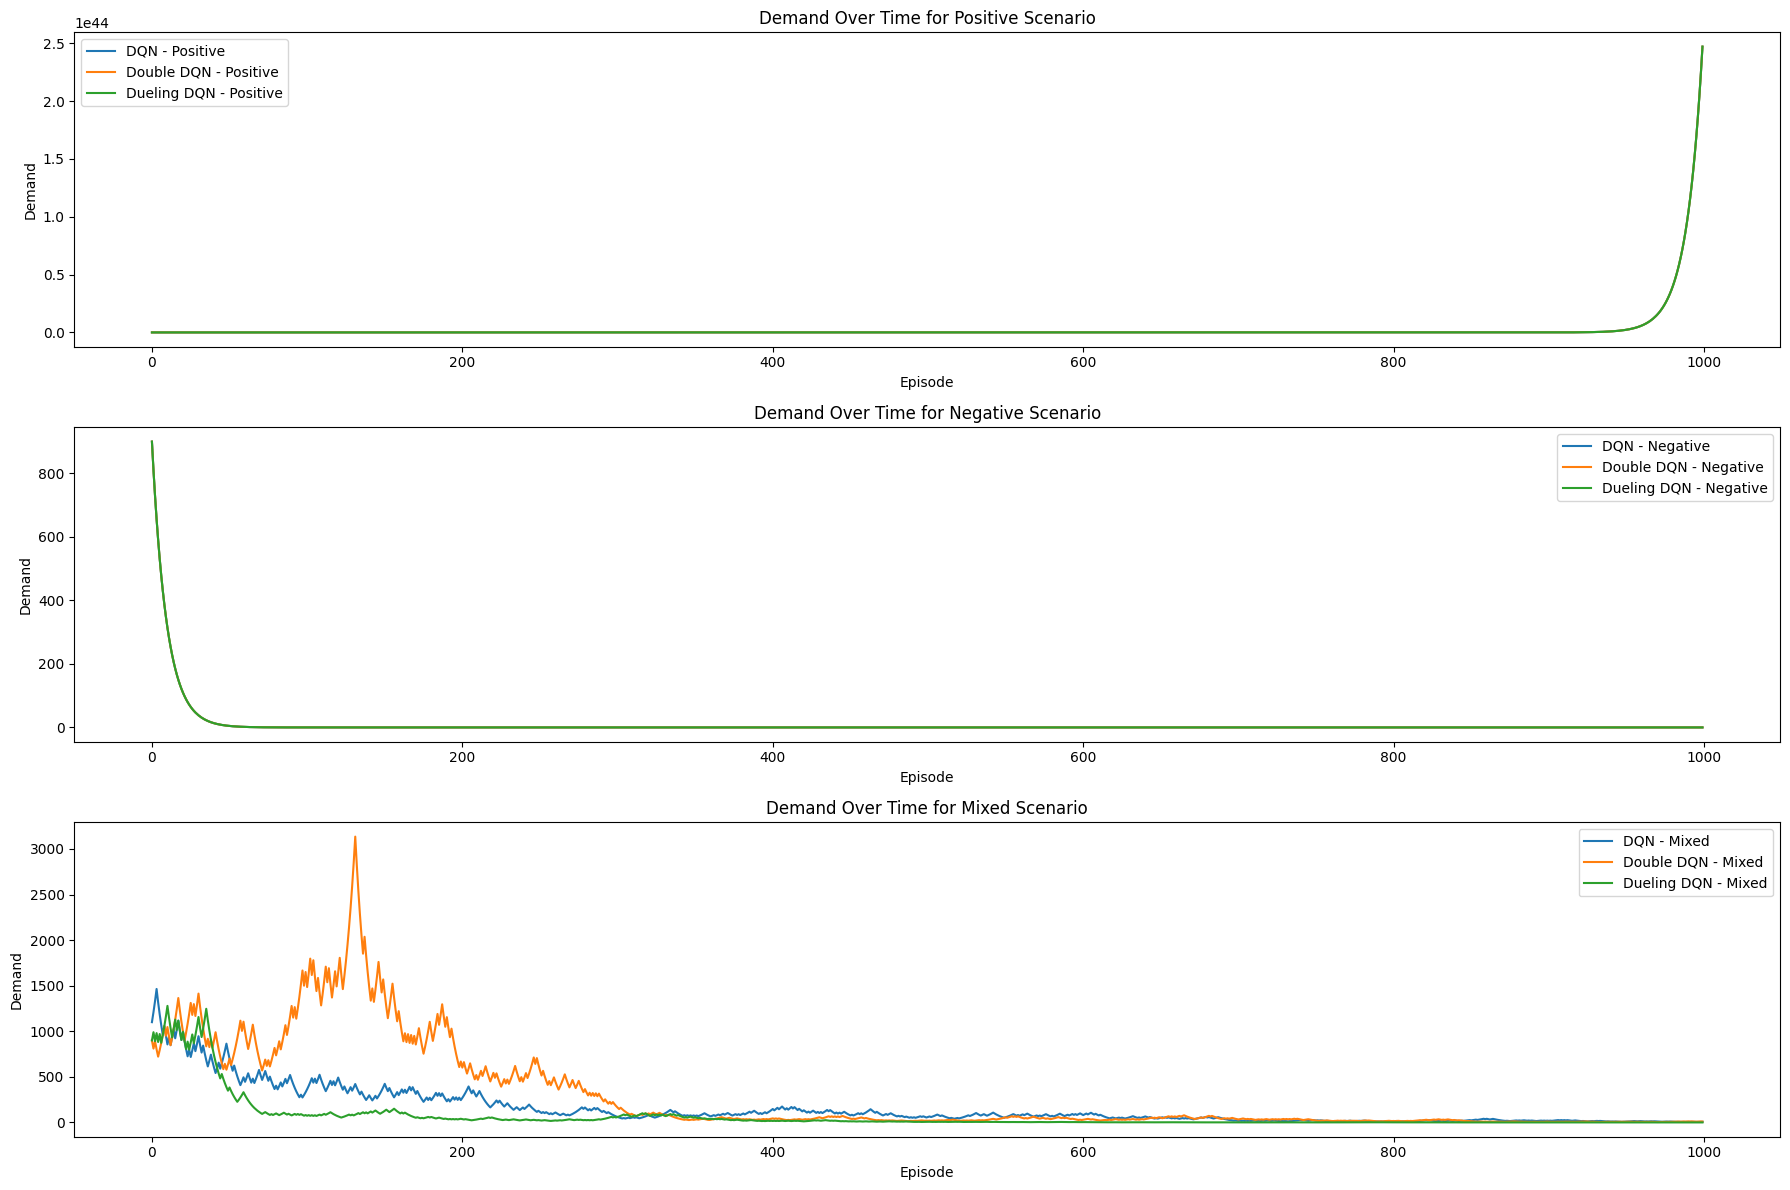

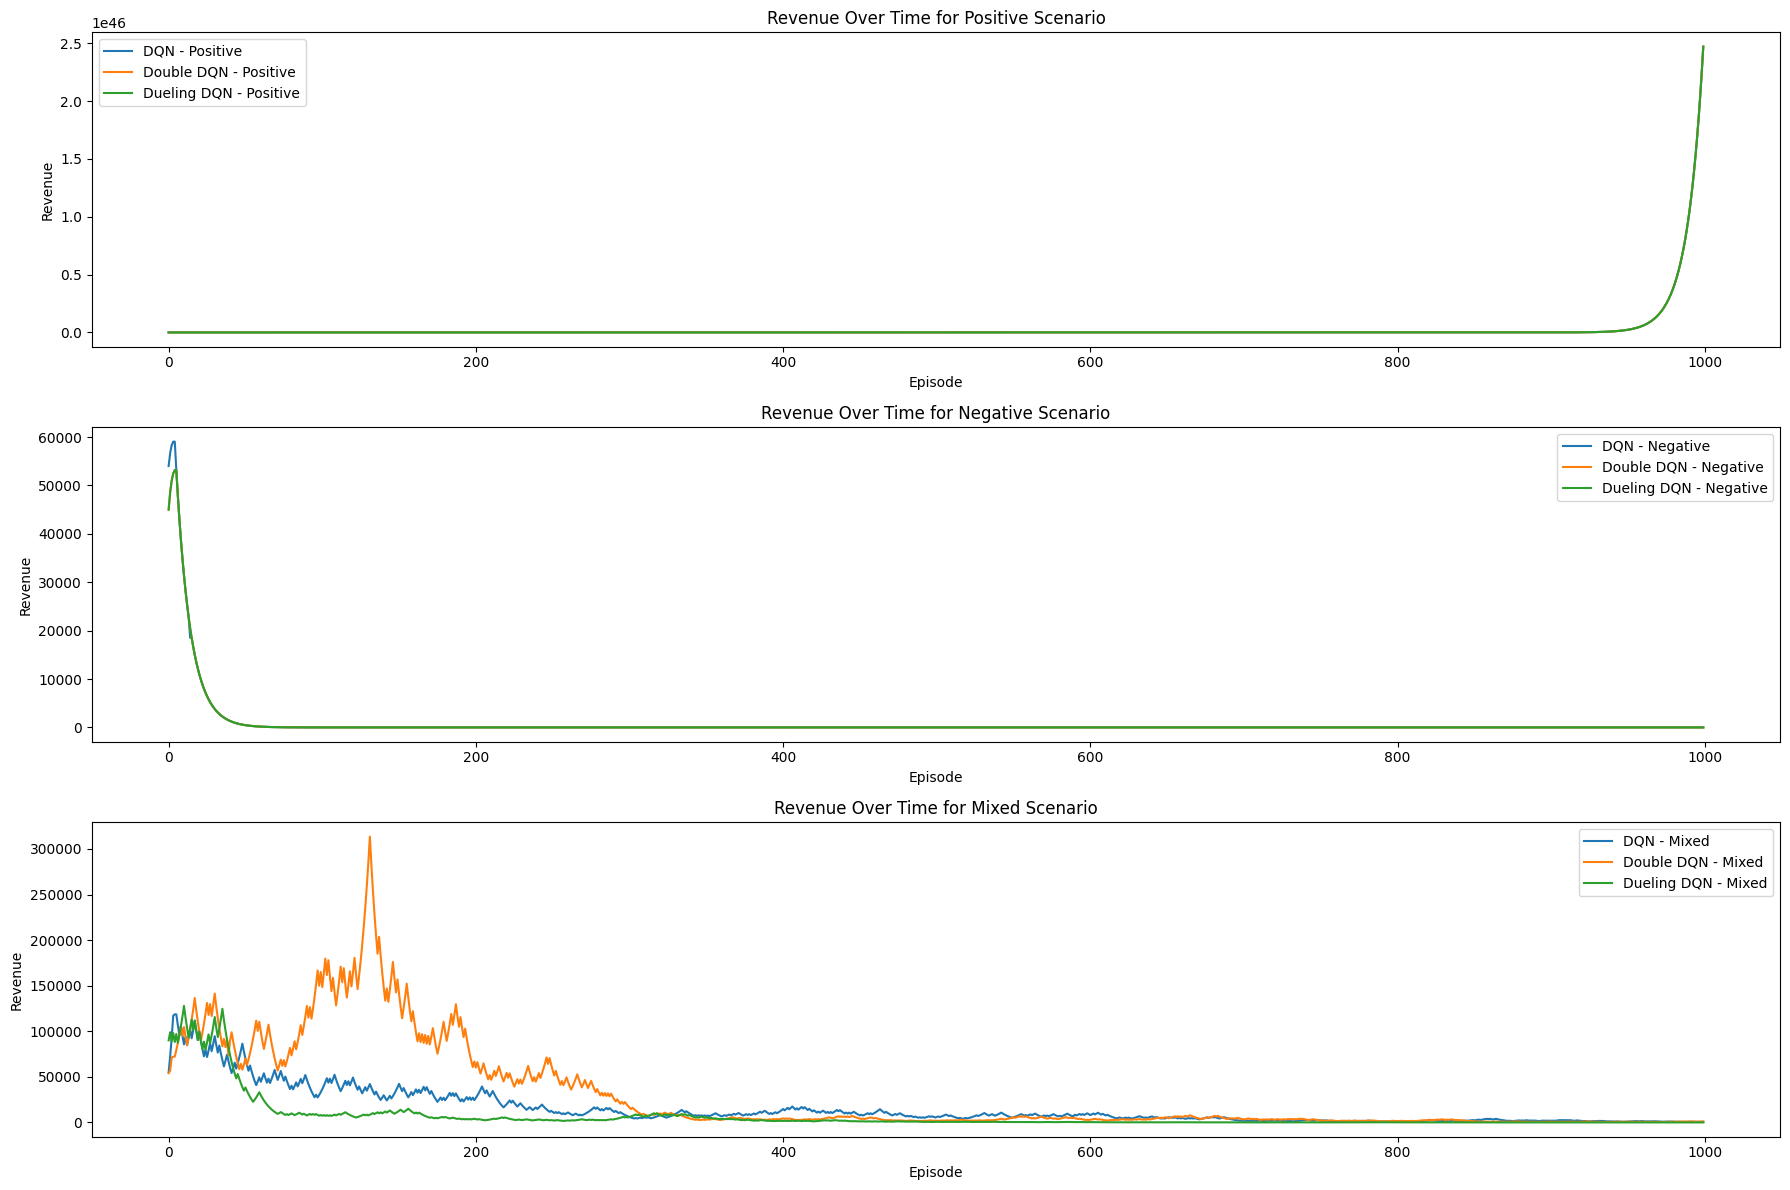

In [ ]:
import matplotlib.pyplot as plt

# Improved Plotting Function
def plot_results(all_results, scenarios, models, metric, title):
    plt.figure(figsize=(18, 12))
    for scenario_idx, scenario in enumerate(scenarios):
        plt.subplot(3, 1, scenario_idx + 1)
        for model_type in models:
            plt.plot(all_results[model_type][scenario][metric], label=f"{model_type} - {scenario}")
        plt.title(f"{title} for {scenario} Scenario")
        plt.xlabel("Episode")
        plt.ylabel(metric)
        plt.legend()
    plt.tight_layout()
    plt.show()

# List of Models and Scenarios
models = ["DQN", "Double DQN", "Dueling DQN"]
scenarios = ["Positive", "Negative", "Mixed"]

# Plot for Each Metric
plot_results(all_results, scenarios, models, "Price", "Price Over Time")
plot_results(all_results, scenarios, models, "Demand", "Demand Over Time")
plot_results(all_results, scenarios, models, "Revenue", "Revenue Over Time")


Running simulation with Positive Factor: 1.01, Negative Factor: 0.99
Running simulation with Positive Factor: 1.01, Negative Factor: 0.95
Running simulation with Positive Factor: 1.01, Negative Factor: 0.9
Running simulation with Positive Factor: 1.05, Negative Factor: 0.99
Running simulation with Positive Factor: 1.05, Negative Factor: 0.95
Running simulation with Positive Factor: 1.05, Negative Factor: 0.9
Running simulation with Positive Factor: 1.1, Negative Factor: 0.99
Running simulation with Positive Factor: 1.1, Negative Factor: 0.95
Running simulation with Positive Factor: 1.1, Negative Factor: 0.9


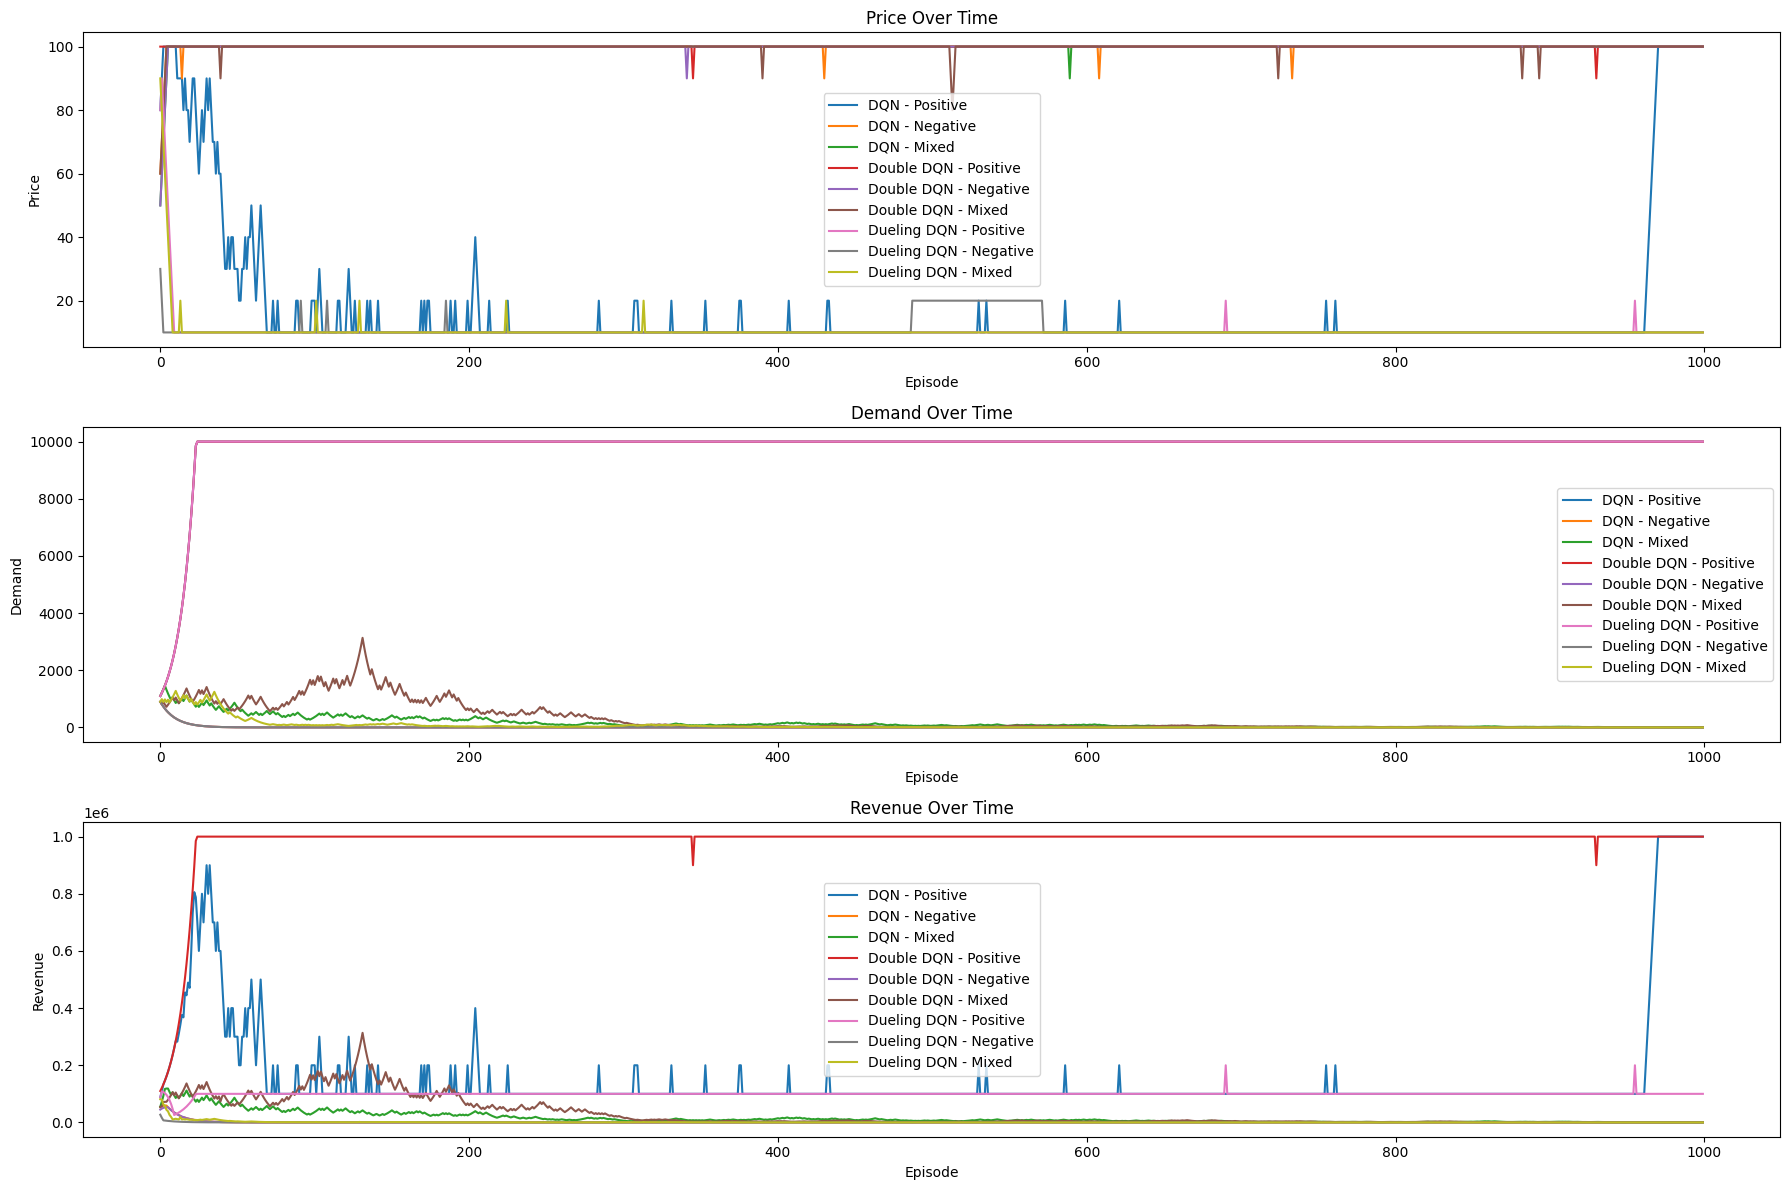

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Lambda
import random
import matplotlib.pyplot as plt
import collections

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Environment parameters
price_range = np.linspace(10, 100, 10)
initial_demand = 1000
episodes = 1000
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
gamma = 0.95
learning_rate = 0.001

# Network effects functions
def positive_network_effect(demand):
    return demand * 1.1

def negative_network_effect(demand):
    return demand * 0.9

def mixed_network_effect(demand):
    if random.random() > 0.5:
        return demand * 1.1
    else:
        return demand * 0.9

# Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size=2000):
        self.buffer = collections.deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states = zip(*batch)
        return np.array(states), actions, rewards, np.array(next_states)

# Dueling DQN model
def build_dueling_dqn_model():
    inputs = Input(shape=(2,))
    hidden = Dense(24, activation='relu')(inputs)
    hidden = Dense(24, activation='relu')(hidden)

    # Dueling Architecture - Separate Value and Advantage streams
    value_stream = Dense(1, activation='linear')(hidden)
    advantage_stream = Dense(3, activation='linear')(hidden)
    q_values = Lambda(lambda v: v[0] + (v[1] - tf.reduce_mean(v[1], axis=1, keepdims=True)))([value_stream, advantage_stream])

    model = Model(inputs=inputs, outputs=q_values)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

# Original DQN Model
def build_dqn_model():
    model = Sequential()
    model.add(Input(shape=(2,)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(3, activation='linear'))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model

# Instantiate models
dqn_model = build_dqn_model()
ddqn_model = build_dqn_model()  # For Double DQN
dueling_dqn_model = build_dueling_dqn_model()

# Initialize target networks
dqn_target_model = build_dqn_model()
dqn_target_model.set_weights(dqn_model.get_weights())

ddqn_target_model = build_dqn_model()
ddqn_target_model.set_weights(ddqn_model.get_weights())

# Change network effect scaling factors for more realistic demand changes
def positive_network_effect(demand):
    return demand * 1.05  # Reduced scaling factor

def mixed_network_effect(demand):
    if random.random() > 0.5:
        return demand * 1.05
    else:
        return demand * 0.95
# Apply a maximum demand cap to avoid unrealistic exponential growth
max_demand = 10000

def positive_network_effect(demand):
    return min(demand * 1.1, max_demand)

def mixed_network_effect(demand):
    if random.random() > 0.5:
        return min(demand * 1.1, max_demand)
    else:
        return max(demand * 0.9, 0)
# Sensitivity analysis: Adjust scaling factors and run multiple simulations
positive_factors = [1.01, 1.05, 1.1]
negative_factors = [0.99, 0.95, 0.9]

for pos_factor in positive_factors:
    for neg_factor in negative_factors:
        print(f"Running simulation with Positive Factor: {pos_factor}, Negative Factor: {neg_factor}")
        # Update network effect functions and re-run simulations

# Simulation Loop Function
def train_model(model, target_model, scenario, batch_size=32, double_dqn=False):
    global epsilon
    results = {"Price": [], "Demand": [], "Revenue": []}
    buffer = ReplayBuffer()
    demand = initial_demand
    price = random.choice(price_range)

    for episode in range(episodes):
        state = np.array([price, demand])

        if np.random.rand() <= epsilon:
            action = random.choice([0, 1, 2])  # Random action
        else:
            action = np.argmax(model.predict(state.reshape(1, 2), verbose=0))

        if action == 0:
            price = min(price + 10, price_range[-1])
        elif action == 1:
            price = max(price - 10, price_range[0])

        if scenario == "Positive":
            demand = positive_network_effect(demand)
        elif scenario == "Negative":
            demand = negative_network_effect(demand)
        elif scenario == "Mixed":
            demand = mixed_network_effect(demand)

        reward = price * demand
        next_state = np.array([price, demand])
        buffer.add((state, action, reward, next_state))

        if len(buffer.buffer) > batch_size:
            states, actions, rewards, next_states = buffer.sample(batch_size)

            # Predict Q-values for current states
            q_values = model.predict(states, verbose=0)

            # Predict Q-values for next states
            if double_dqn:
                # Double DQN: Use main model to select action, target model for evaluation
                next_actions = np.argmax(model.predict(next_states, verbose=0), axis=1)
                q_values_next = target_model.predict(next_states, verbose=0)
                targets = rewards + gamma * q_values_next[np.arange(batch_size), next_actions]
            else:
                # Standard DQN and Dueling DQN
                q_values_next = target_model.predict(next_states, verbose=0)
                targets = rewards + gamma * np.max(q_values_next, axis=1)

            # Update Q-values for the selected actions
            for idx, action in enumerate(actions):
                q_values[idx][action] = targets[idx]

            # Train the main model
            model.fit(states, q_values, epochs=1, verbose=0)

        state = next_state
        results["Price"].append(price)
        results["Demand"].append(demand)
        results["Revenue"].append(reward)

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        if episode % 10 == 0:
            target_model.set_weights(model.get_weights())

    return results

# Run DQN, Double DQN, and Dueling DQN
scenarios = ["Positive", "Negative", "Mixed"]
all_results = {"DQN": {}, "Double DQN": {}, "Dueling DQN": {}}

# Train each model under all scenarios
for scenario in scenarios:
    all_results["DQN"][scenario] = train_model(dqn_model, dqn_target_model, scenario)
    all_results["Double DQN"][scenario] = train_model(ddqn_model, ddqn_target_model, scenario, double_dqn=True)
    all_results["Dueling DQN"][scenario] = train_model(dueling_dqn_model, dueling_dqn_model, scenario)

# Plot results
plt.figure(figsize=(18, 12))

for i, metric in enumerate(["Price", "Demand", "Revenue"]):
    plt.subplot(3, 1, i + 1)
    for model_type in ["DQN", "Double DQN", "Dueling DQN"]:
        for scenario in scenarios:
            plt.plot(all_results[model_type][scenario][metric], label=f"{model_type} - {scenario}")
    plt.title(f"{metric} Over Time")
    plt.xlabel("Episode")
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()


Visualizing Positive Scenario


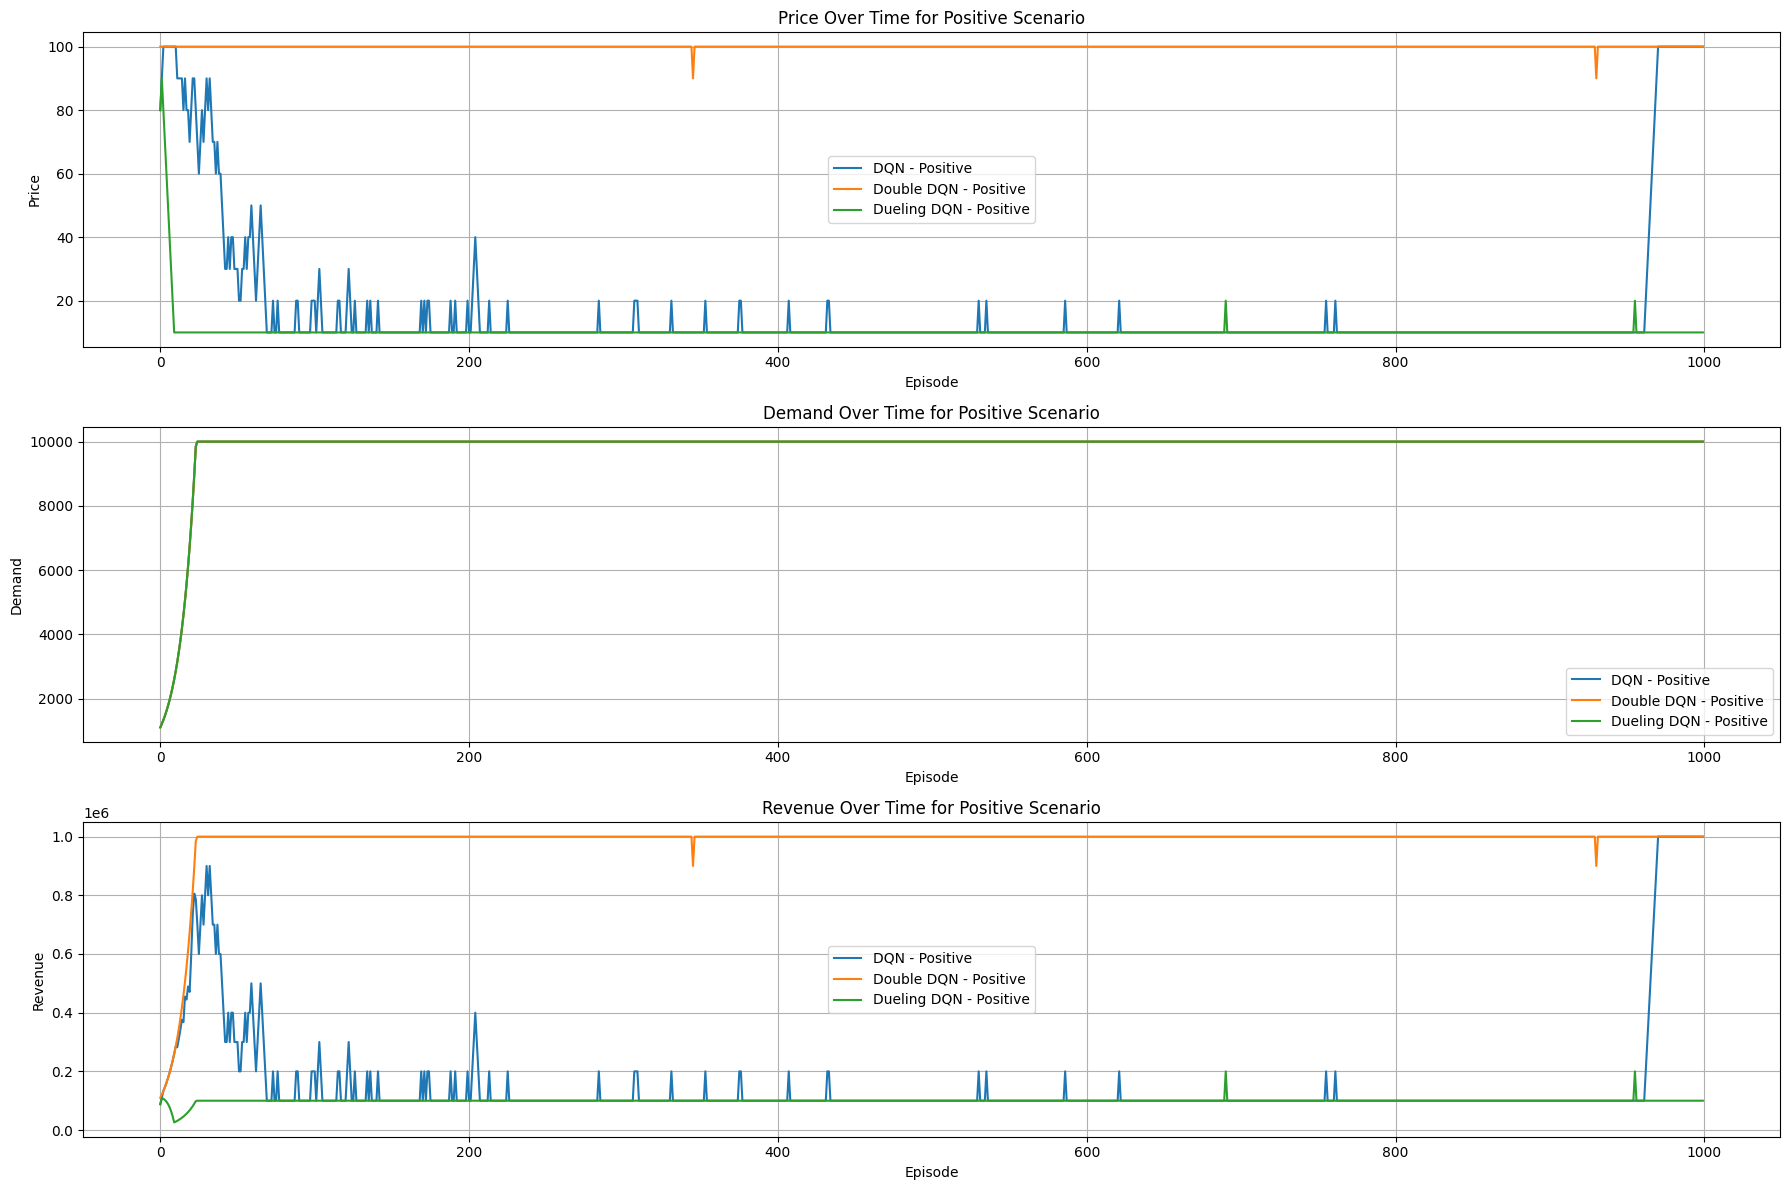

Visualizing Negative Scenario


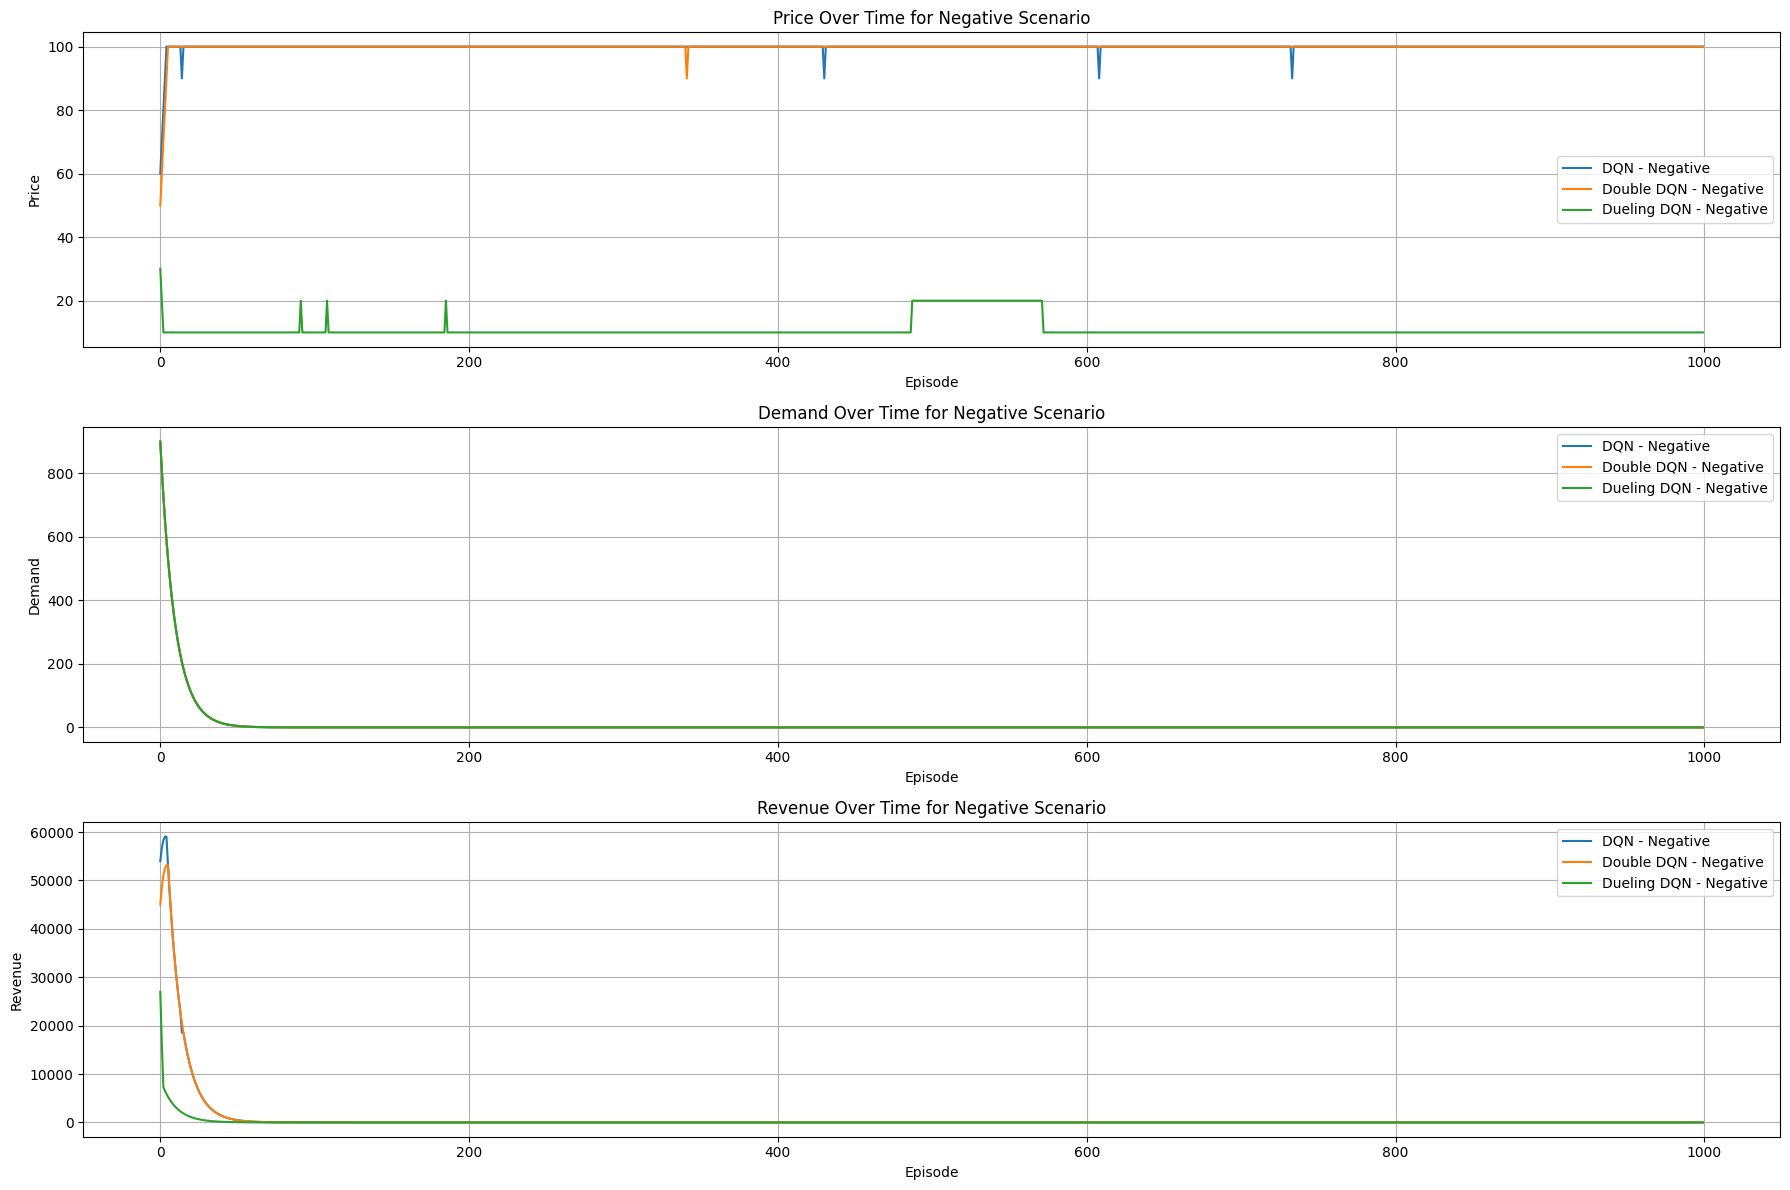

Visualizing Mixed Scenario


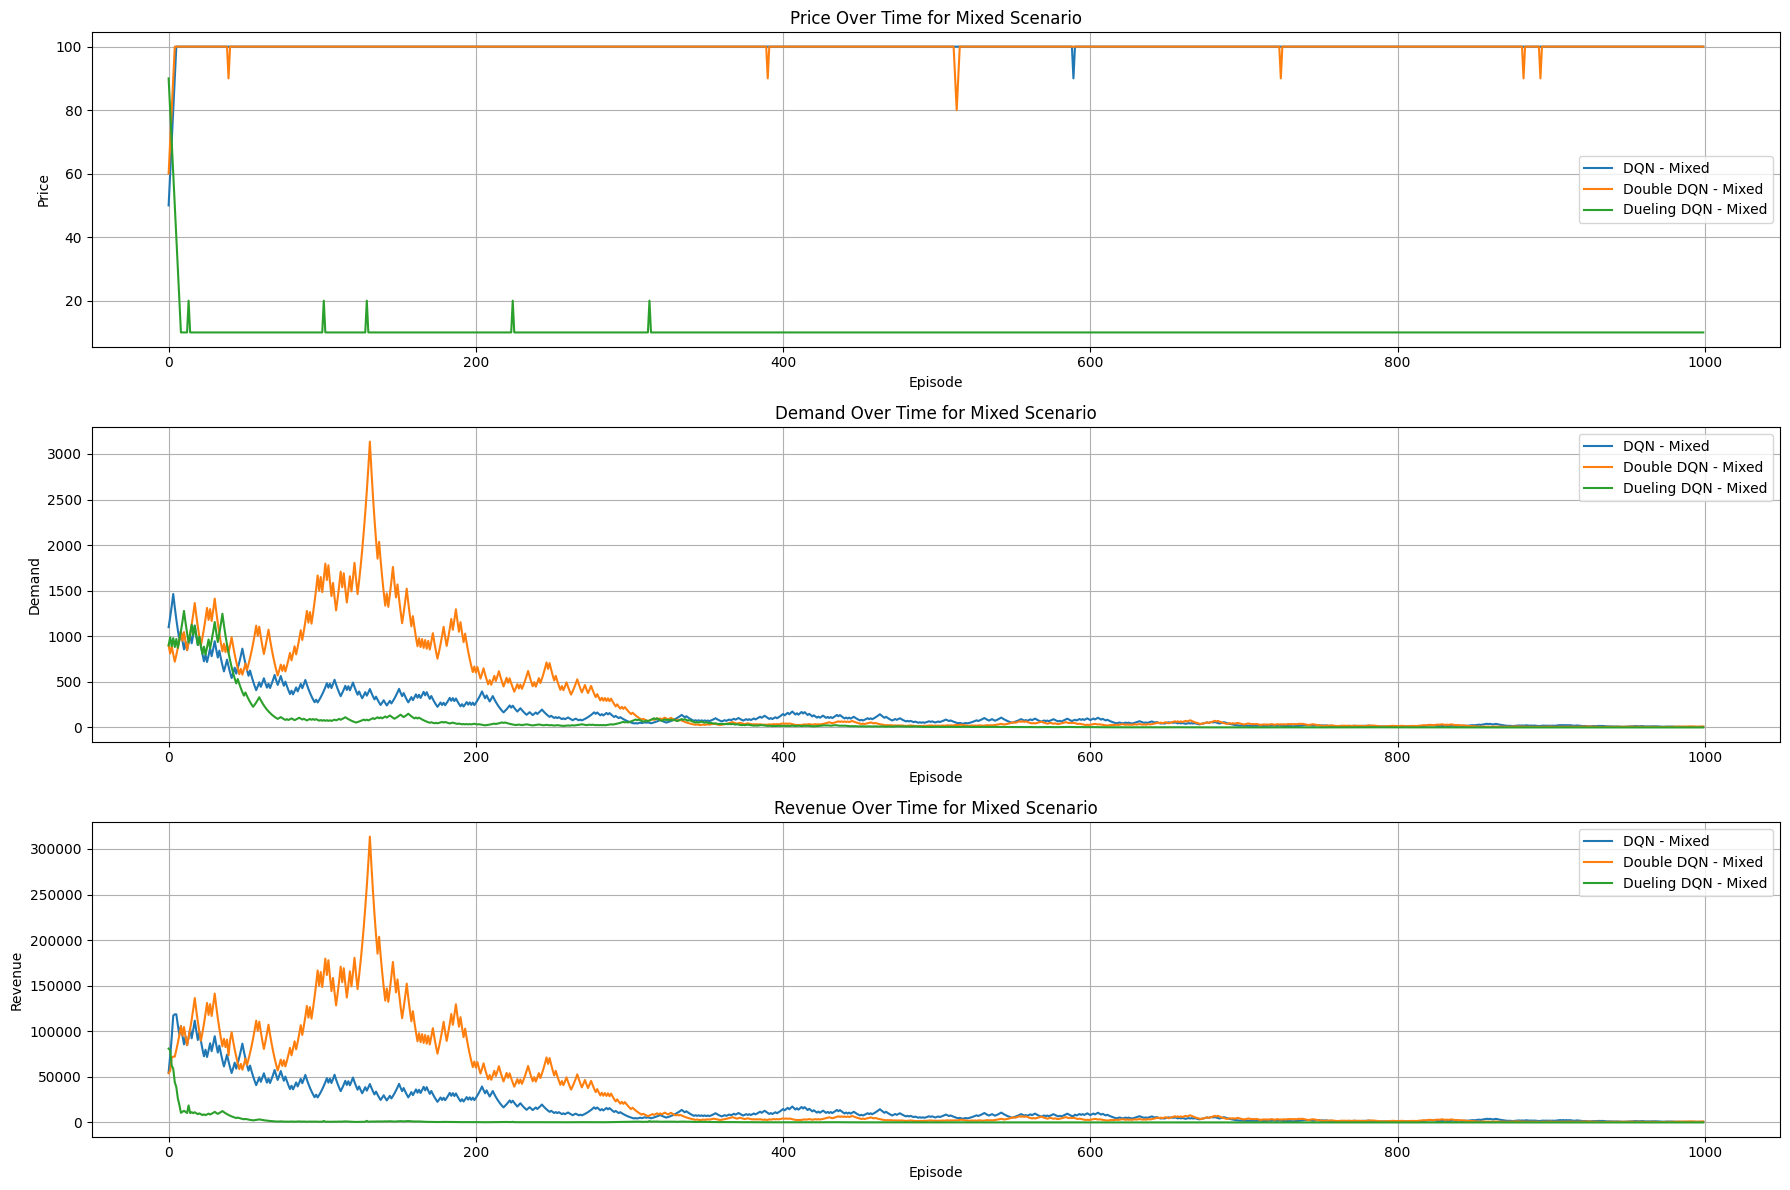

In [2]:
import matplotlib.pyplot as plt

# Improved Plotting Function for Each Scenario
def plot_results_by_scenario(all_results, scenario, models):
    metrics = ["Price", "Demand", "Revenue"]
    plt.figure(figsize=(18, 12))

    for metric_idx, metric in enumerate(metrics):
        plt.subplot(3, 1, metric_idx + 1)
        for model_type in models:
            plt.plot(all_results[model_type][scenario][metric], label=f"{model_type} - {scenario}")
        plt.title(f"{metric} Over Time for {scenario} Scenario")
        plt.xlabel("Episode")
        plt.ylabel(metric)
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

# List of Models and Scenarios
models = ["DQN", "Double DQN", "Dueling DQN"]
scenarios = ["Positive", "Negative", "Mixed"]

# Plot each scenario separately
for scenario in scenarios:
    print(f"Visualizing {scenario} Scenario")
    plot_results_by_scenario(all_results, scenario, models)


Visualizing DQN Model


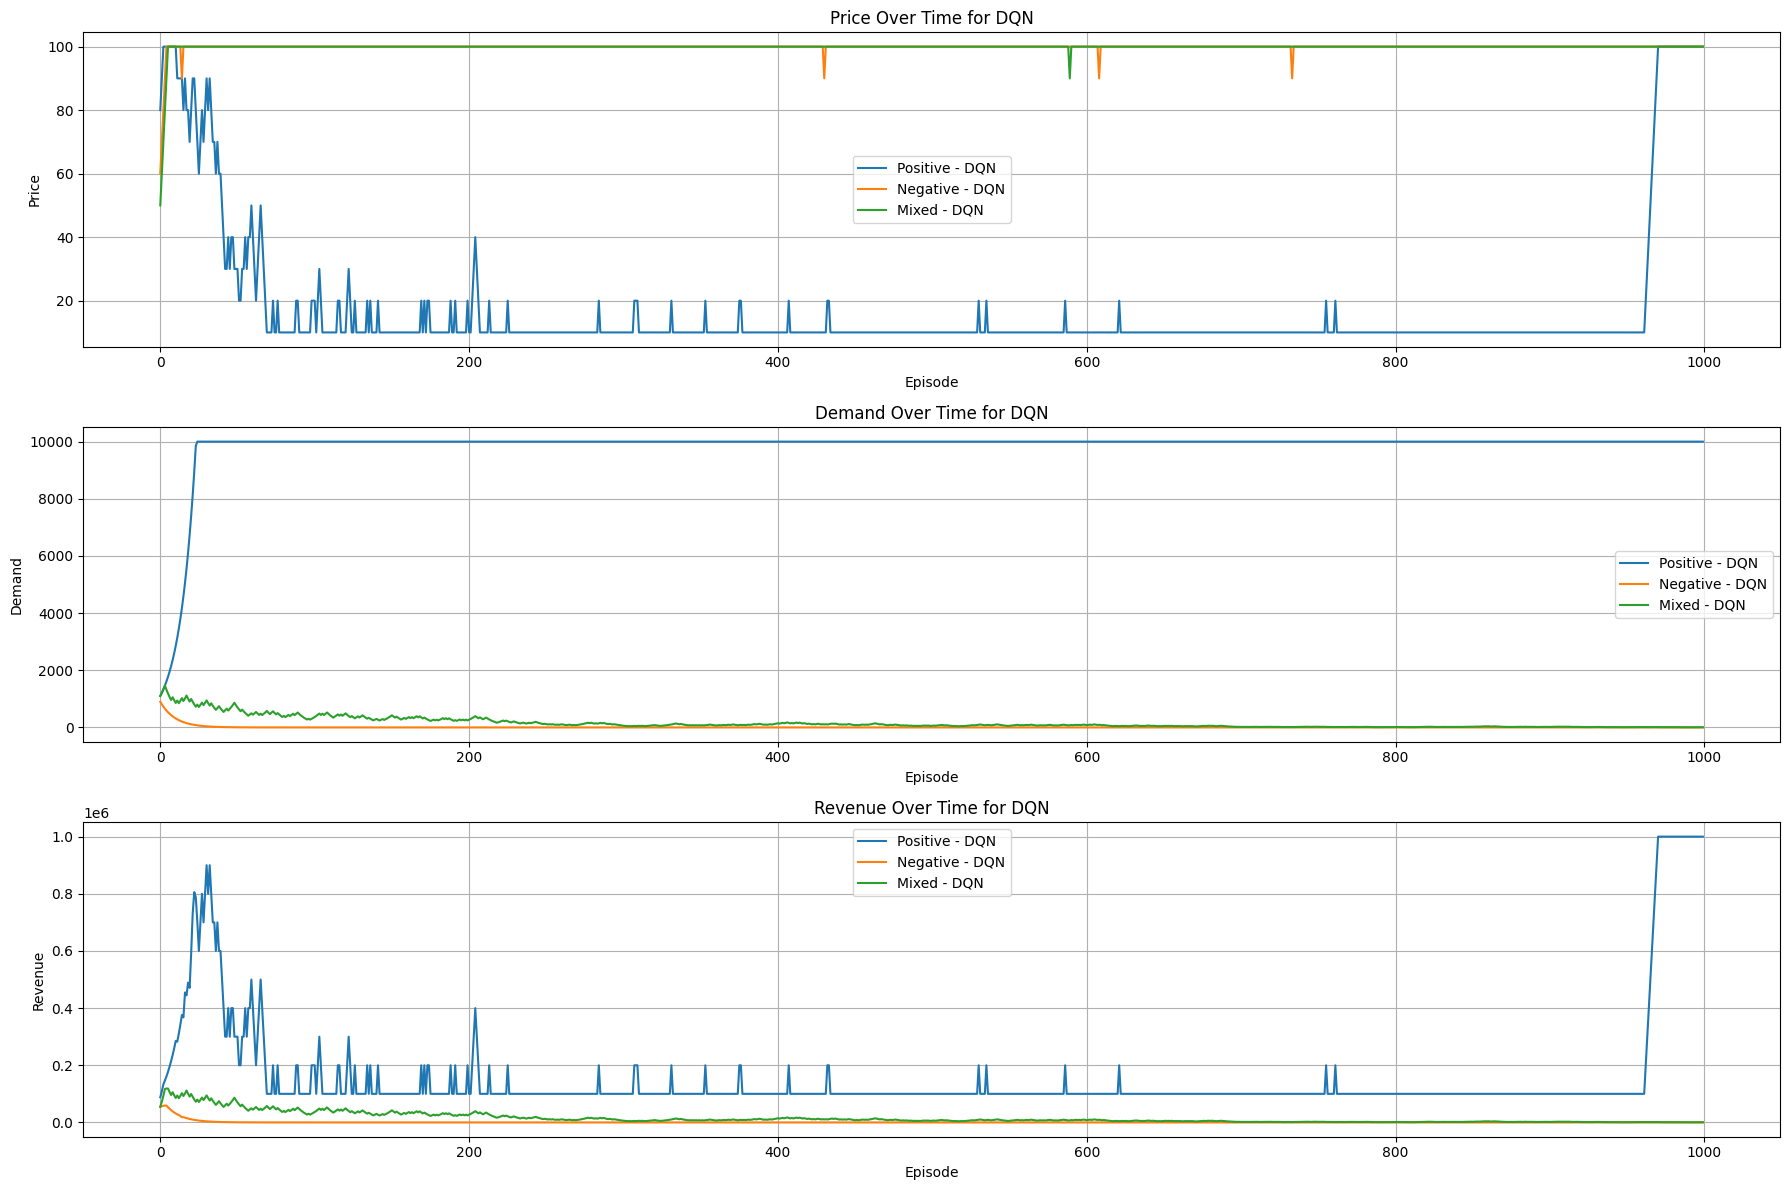

Visualizing Double DQN Model


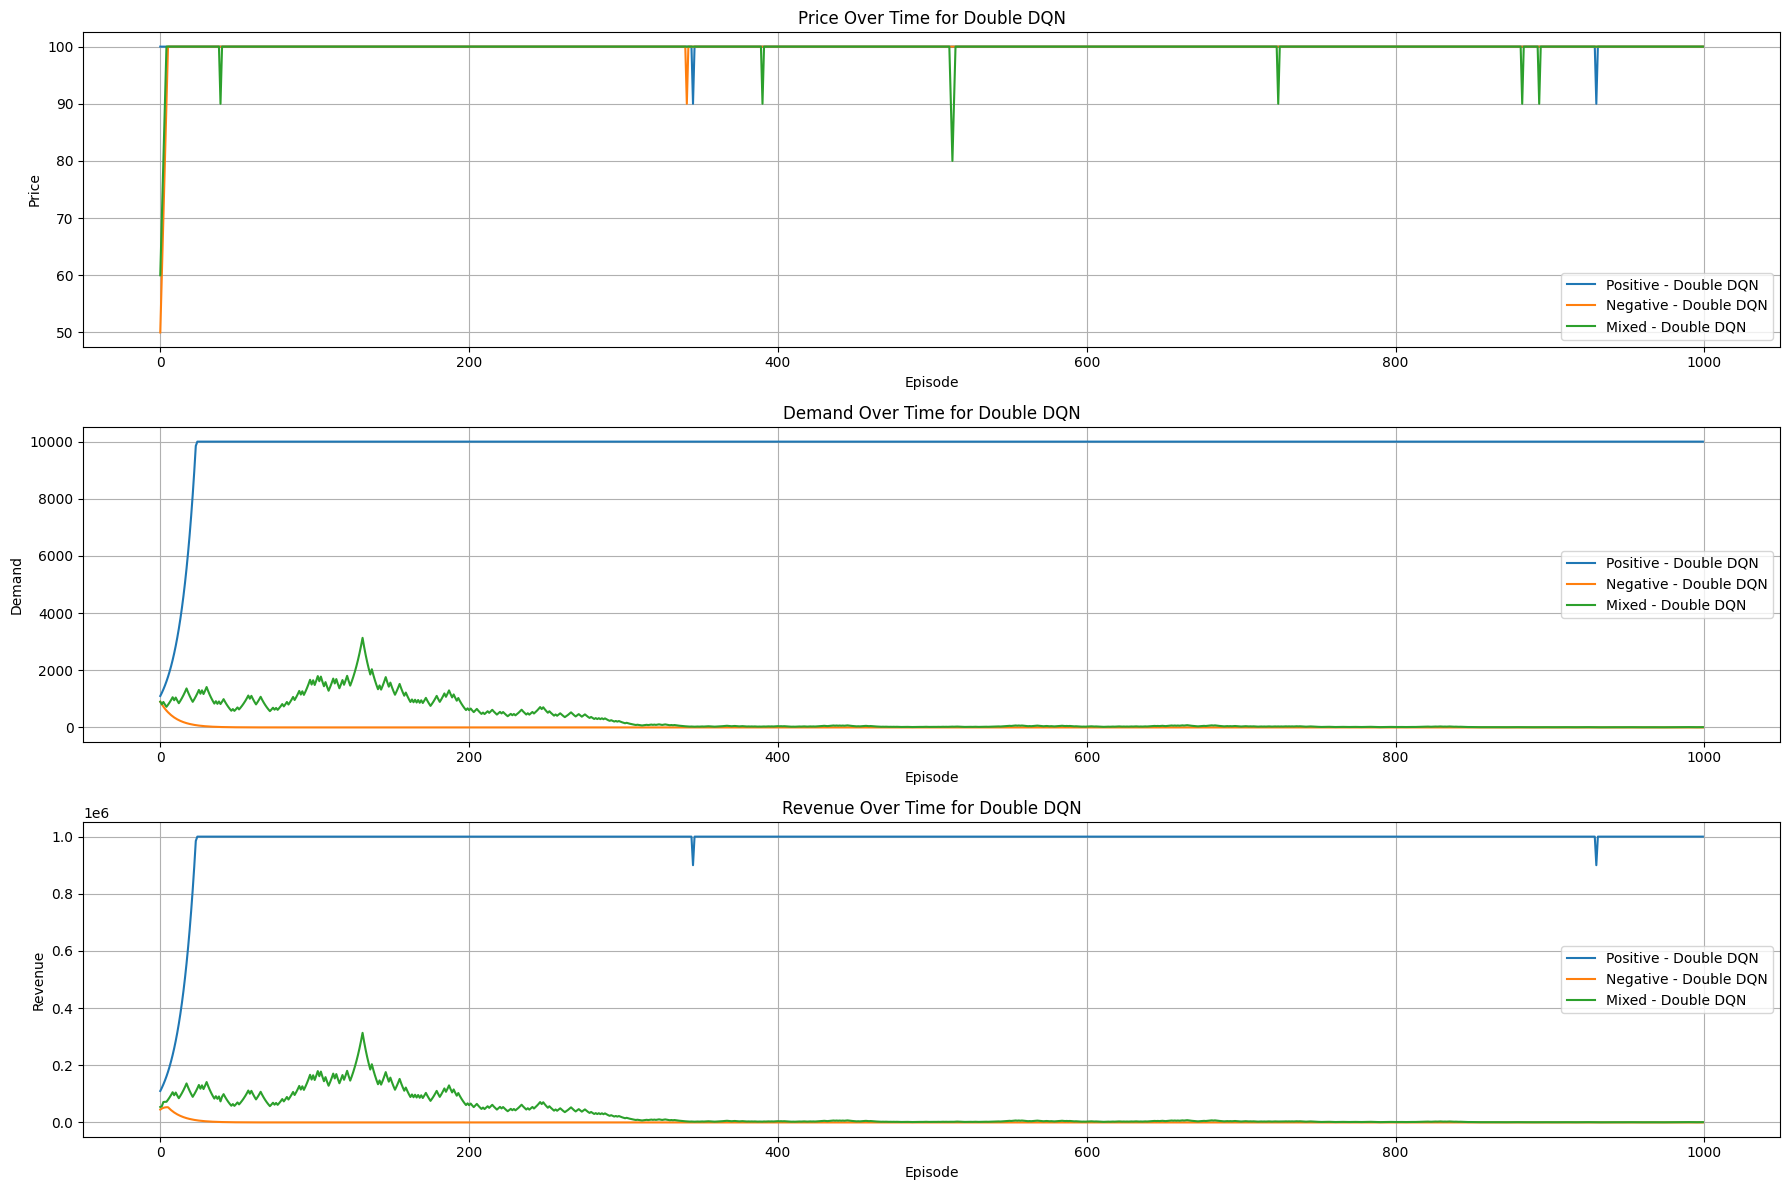

Visualizing Dueling DQN Model


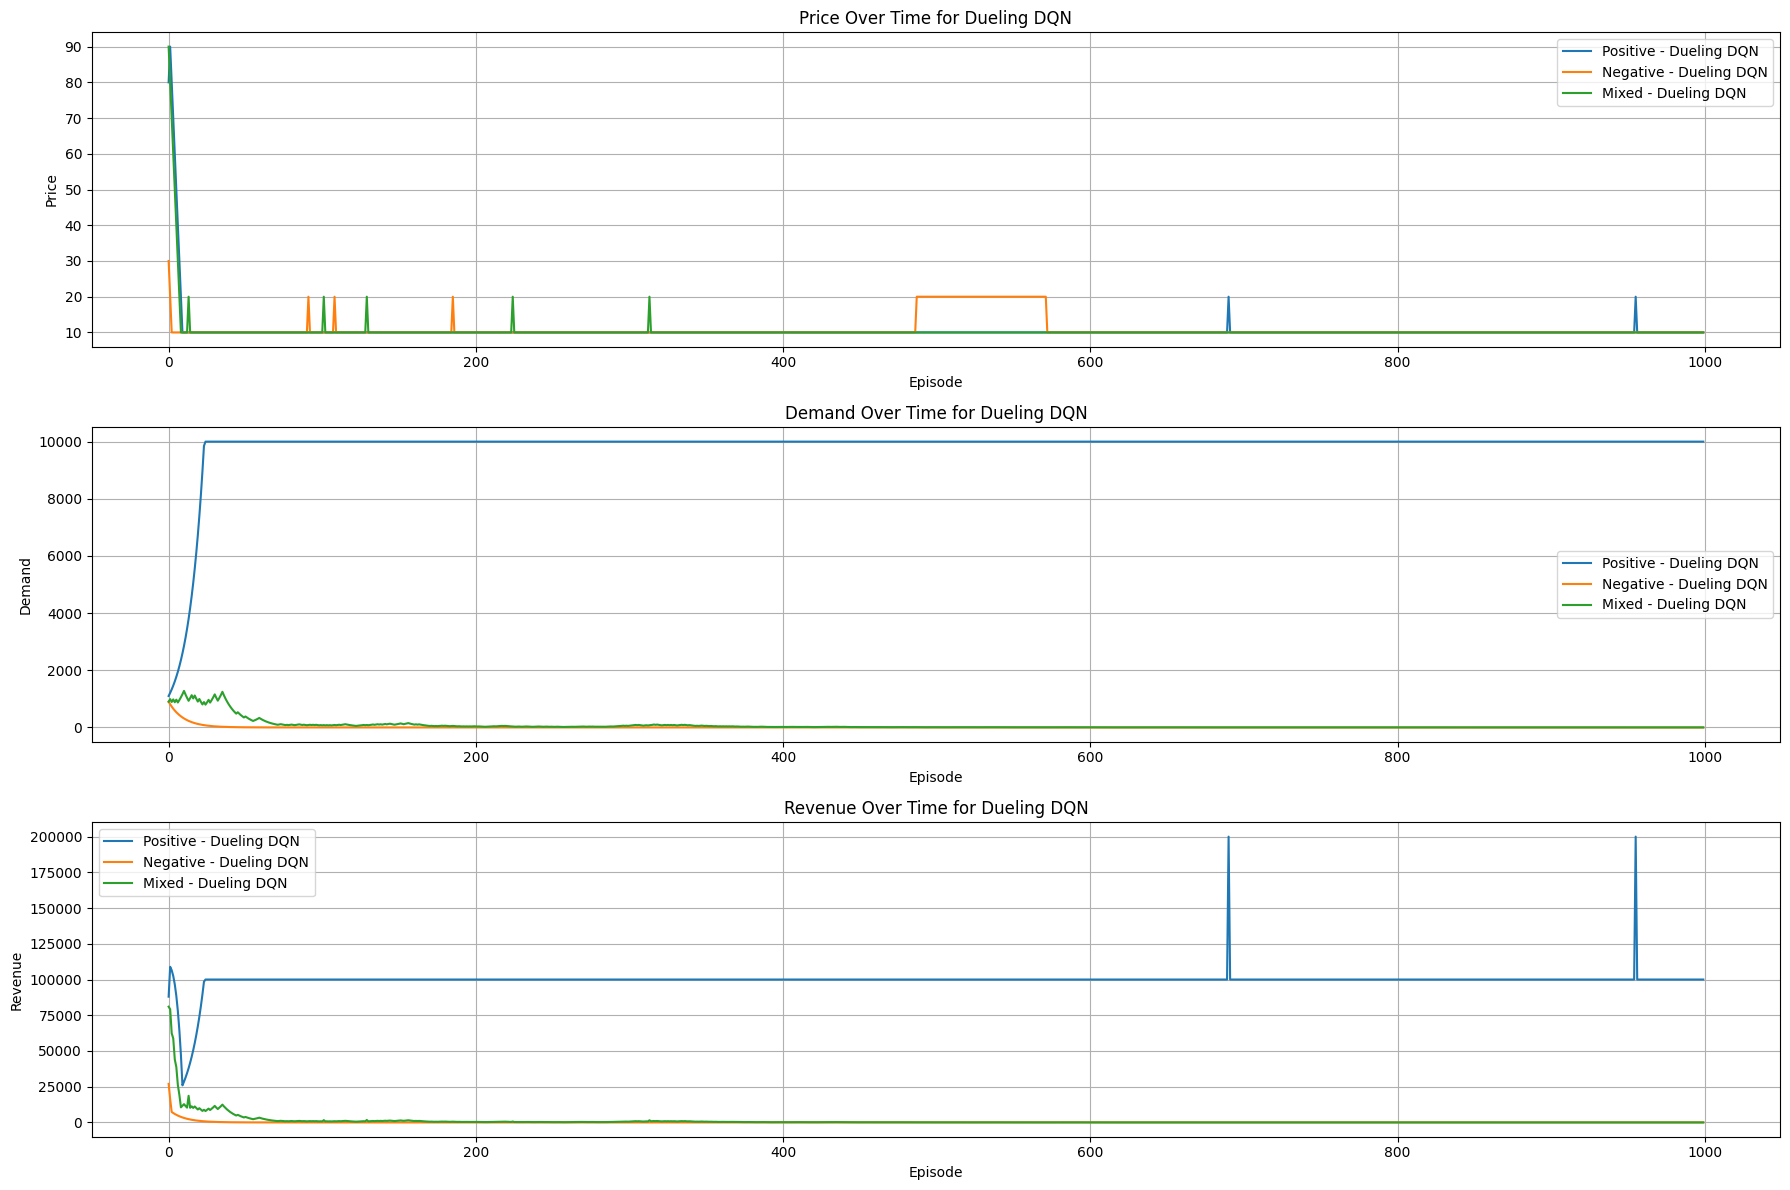

In [3]:
# Improved Plotting Function for Each Model
def plot_results_by_model(all_results, model_type, scenarios):
    metrics = ["Price", "Demand", "Revenue"]
    plt.figure(figsize=(18, 12))

    for metric_idx, metric in enumerate(metrics):
        plt.subplot(3, 1, metric_idx + 1)
        for scenario in scenarios:
            plt.plot(all_results[model_type][scenario][metric], label=f"{scenario} - {model_type}")
        plt.title(f"{metric} Over Time for {model_type}")
        plt.xlabel("Episode")
        plt.ylabel(metric)
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

# List of Models and Scenarios
models = ["DQN", "Double DQN", "Dueling DQN"]

# Plot each model separately
for model_type in models:
    print(f"Visualizing {model_type} Model")
    plot_results_by_model(all_results, model_type, scenarios)


Metrics Summary Table:
         Model  Scenario  Cumulative Revenue  Average Revenue  \
0          DQN  Positive        1.592612e+08    159261.220368   
1          DQN  Negative        8.165001e+05       816.500089   
2          DQN     Mixed        1.517144e+07     15171.437375   
3   Double DQN  Positive        9.855347e+08    985534.705943   
4   Double DQN  Negative        7.817031e+05       781.703100   
5   Double DQN     Mixed        3.019309e+07     30193.091716   
6  Dueling DQN  Positive        9.940459e+07     99404.587300   
7  Dueling DQN  Negative        1.161007e+05       116.100720   
8  Dueling DQN     Mixed        1.059072e+06      1059.071760   

   Price Stability (std dev)  Demand Stability (std dev)  
0                  21.399474                  992.950707  
1                   1.838586                   64.669606  
2                   2.361017                  213.917841  
3                   0.446766                  992.950707  
4                   2.361017   

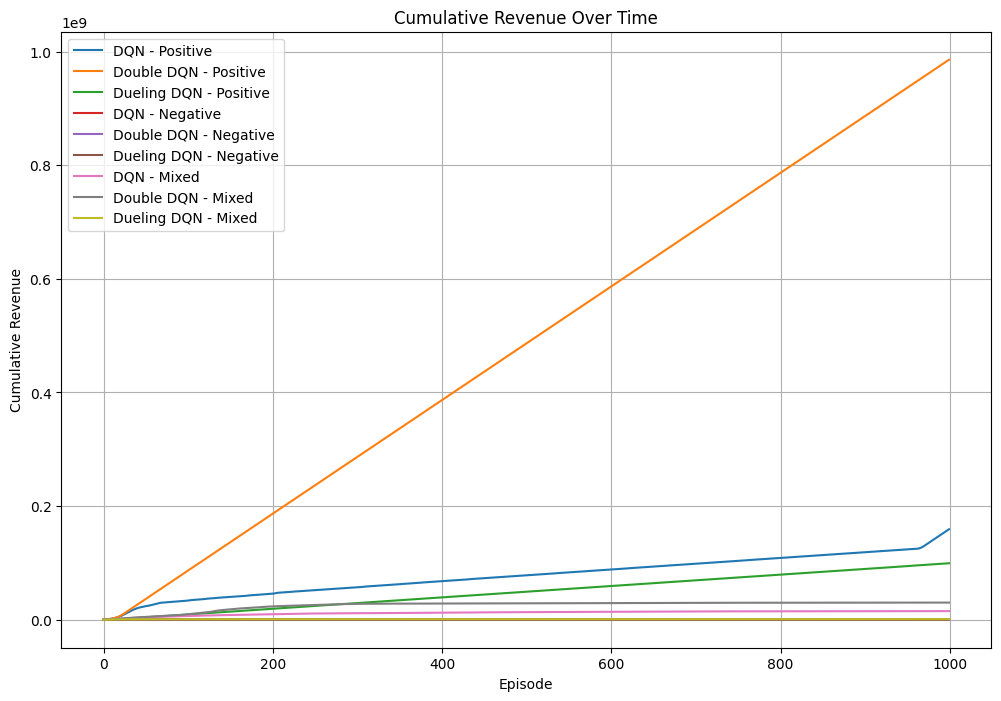

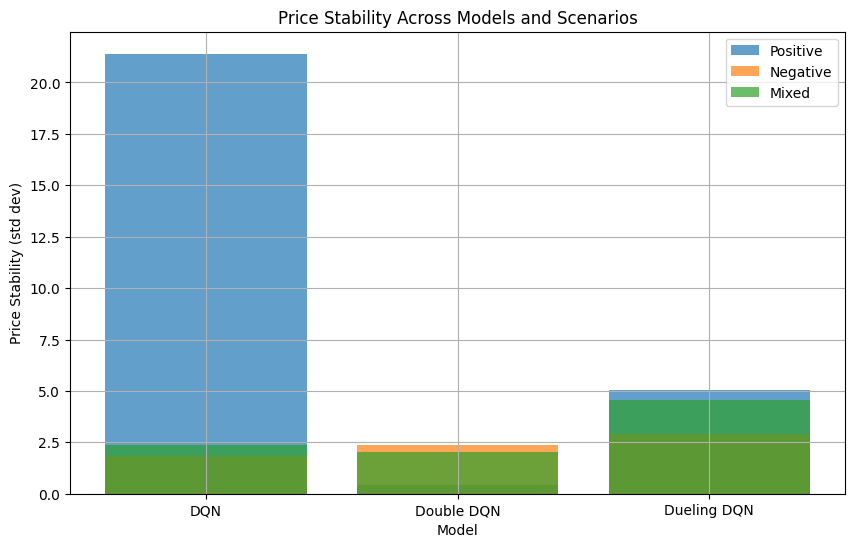

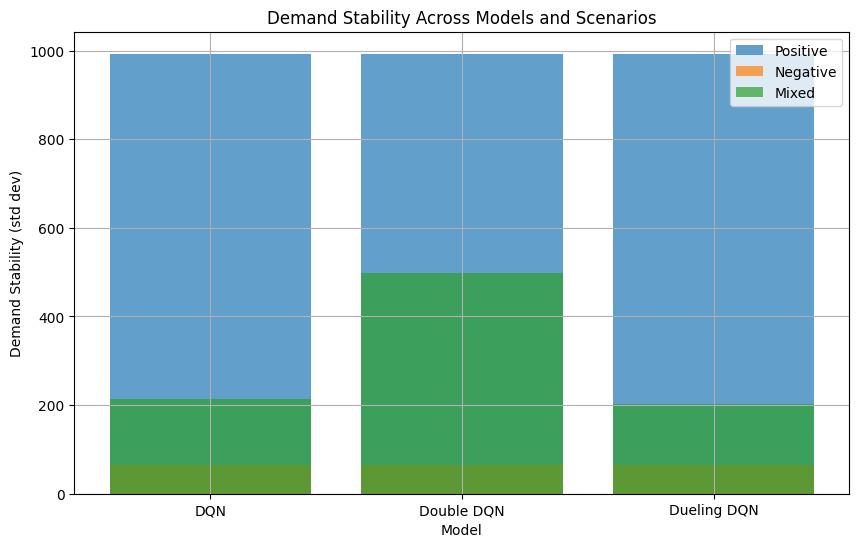

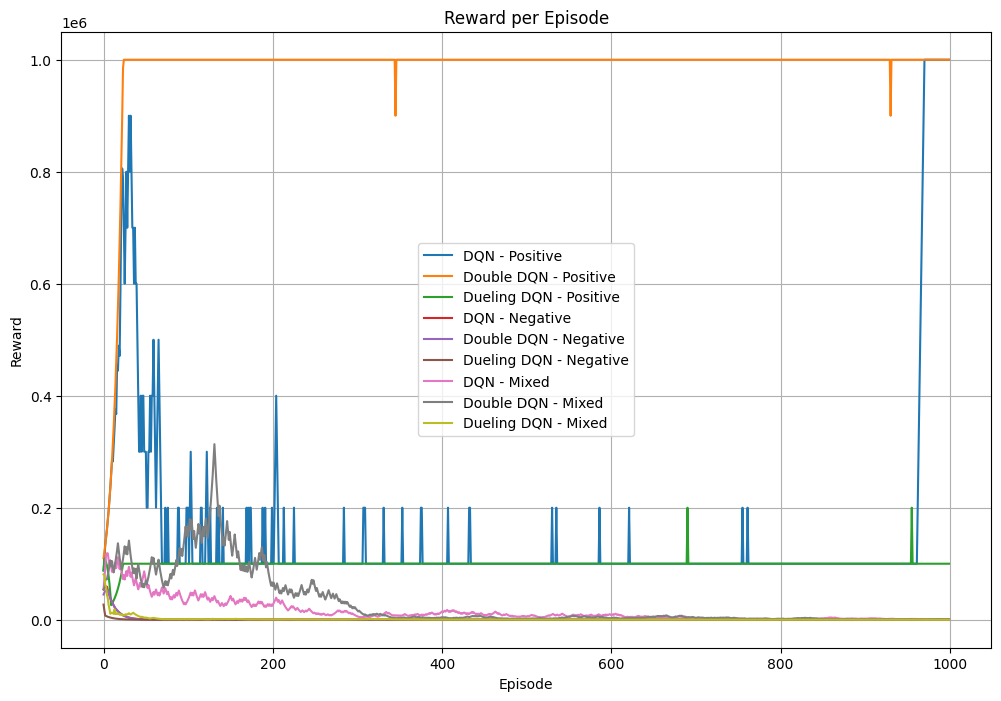

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Menghitung Cumulative Revenue, Average Revenue, dan Price/Demand Stability untuk Setiap Model dan Skenario
def calculate_metrics(all_results, models, scenarios):
    metrics_summary = []

    for model in models:
        for scenario in scenarios:
            results = all_results[model][scenario]
            cumulative_revenue = np.cumsum(results["Revenue"])
            average_revenue = np.mean(results["Revenue"])
            price_stability = np.std(results["Price"])  # Standard deviation of price as a measure of stability
            demand_stability = np.std(results["Demand"])  # Standard deviation of demand as a measure of stability

            # Append the results to the summary
            metrics_summary.append({
                "Model": model,
                "Scenario": scenario,
                "Cumulative Revenue": cumulative_revenue[-1],  # Total cumulative revenue at the end
                "Average Revenue": average_revenue,
                "Price Stability (std dev)": price_stability,
                "Demand Stability (std dev)": demand_stability
            })

    # Create a DataFrame for easier visualization
    return pd.DataFrame(metrics_summary)

# Step 2: Plot Cumulative Revenue Over Time untuk Setiap Model dan Skenario
def plot_cumulative_revenue(all_results, models, scenarios):
    plt.figure(figsize=(12, 8))

    for scenario in scenarios:
        for model in models:
            cumulative_revenue = np.cumsum(all_results[model][scenario]["Revenue"])
            plt.plot(cumulative_revenue, label=f"{model} - {scenario}")

    plt.title("Cumulative Revenue Over Time")
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Revenue")
    plt.legend()
    plt.grid()
    plt.show()

# Step 3: Plot Stability Analysis untuk Price dan Demand
def plot_stability(metrics_df, stability_metric, title):
    plt.figure(figsize=(10, 6))
    for scenario in metrics_df["Scenario"].unique():
        subset = metrics_df[metrics_df["Scenario"] == scenario]
        plt.bar(subset["Model"], subset[stability_metric], alpha=0.7, label=f"{scenario}")

    plt.title(title)
    plt.xlabel("Model")
    plt.ylabel(stability_metric)
    plt.legend()
    plt.grid()
    plt.show()

# Step 4: Plot Reward Per Episode untuk Melihat Tren Reward
def plot_reward_trends(all_results, models, scenarios):
    plt.figure(figsize=(12, 8))

    for scenario in scenarios:
        for model in models:
            plt.plot(all_results[model][scenario]["Revenue"], label=f"{model} - {scenario}")

    plt.title("Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid()
    plt.show()

# Memanggil Fungsi untuk Menghitung dan Memvisualisasikan Metrik Kinerja
models = ["DQN", "Double DQN", "Dueling DQN"]
scenarios = ["Positive", "Negative", "Mixed"]

# Calculate metrics summary
metrics_df = calculate_metrics(all_results, models, scenarios)

# Print summary table
print("Metrics Summary Table:")
print(metrics_df)

# Step 2: Visualisasi Cumulative Revenue
plot_cumulative_revenue(all_results, models, scenarios)

# Step 3: Visualisasi Price Stability
plot_stability(metrics_df, "Price Stability (std dev)", "Price Stability Across Models and Scenarios")

# Step 4: Visualisasi Demand Stability
plot_stability(metrics_df, "Demand Stability (std dev)", "Demand Stability Across Models and Scenarios")

# Step 5: Visualisasi Reward Trends
plot_reward_trends(all_results, models, scenarios)
